# Prediction of Rare Latency Events

## Setup

### Preprocessing

The latency data in this git repository only contain the data of one single network flow of the original 3 GB CSV file. Additionaly, all columns apart from the time and latency columns were removed.

### Basic setup

In [1]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')

from scipy.stats import norm
from scipy.stats import genpareto

from thresholdmodeling import thresh_modeling

from rpy2.robjects.vectors import FloatVector
from rpy2.robjects.packages import importr

POT = importr('POT')

In [2]:
ldata = pd.read_csv('latency_data.csv')

We convert the time values from nanoseconds to seconds and the latency values from nanoseconds to seconds. On top of that, we only consider the time values relative to the time the first packet was sent.

In [3]:
ldata['time'] -= ldata['time'].min()
ldata['time'] /= 1000000000
ldata['latency'] /= 1000

## Block Maxima and Threshold Models

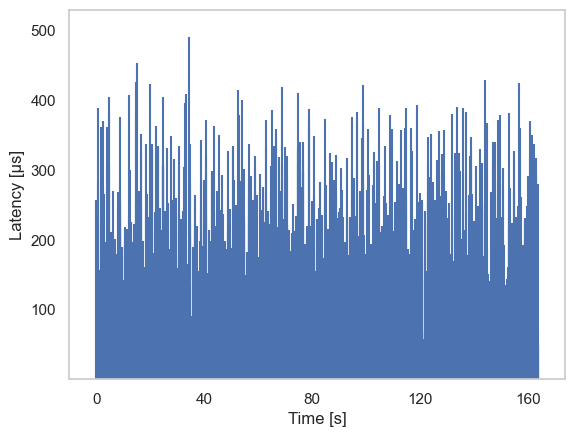

In [4]:
border = 10

plt.grid()
plt.stem(ldata['time'], ldata['latency'], linefmt='#4c72b0', markerfmt='none', basefmt='none')
plt.axis([-border, ldata['time'].max()+border, 0, 530])
plt.xticks([0, 40, 80, 120, 160])
plt.xlabel('Time [s]')
plt.yticks([100, 200, 300, 400, 500])
plt.ylabel('Latency [μs]')
plt.show()

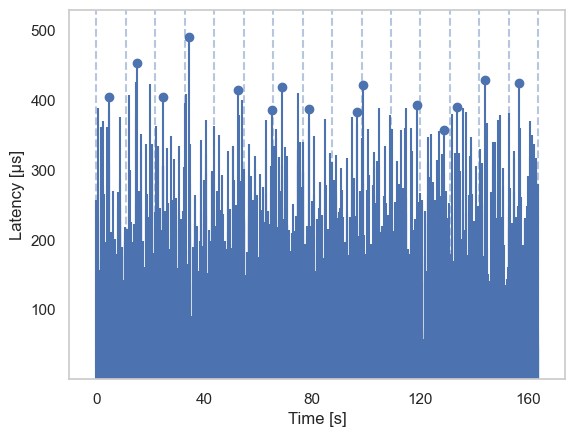

In [5]:
blocks = []
indices = []
num_blocks = 15
block_size = ldata['time'].max()/num_blocks

for b in range(mt.ceil(ldata['time'].max()/block_size)):
    block = ldata[(ldata['time'] >= b*block_size) & (ldata['time'] < (b+1)*block_size)]
    indices.append(block['latency'].idxmax())
    blocks.append(block)
    
maxima = ldata[np.isin(ldata.index.values, indices)]
remaining = ldata[np.logical_not(np.isin(ldata.index.values, indices))]

for xc in np.arange(0, ldata['time'].max() + block_size, block_size):
    plt.axvline(x=xc, color='#b7c6df', linestyle='dashed')
    
plt.stem(remaining['time'], remaining['latency'], linefmt='#4c72b0', markerfmt='none', basefmt='none')
markerline, _, _ = plt.stem(maxima['time'], maxima['latency'], linefmt='#4c72b0', markerfmt='o', basefmt='none')
plt.axis([-border, ldata['time'].max()+border, 0, 530])
plt.xticks([0, 40, 80, 120, 160])
plt.xlabel('Time [s]')
plt.yticks([100, 200, 300, 400, 500])
plt.ylabel('Latency [μs]')
plt.grid()
plt.show()

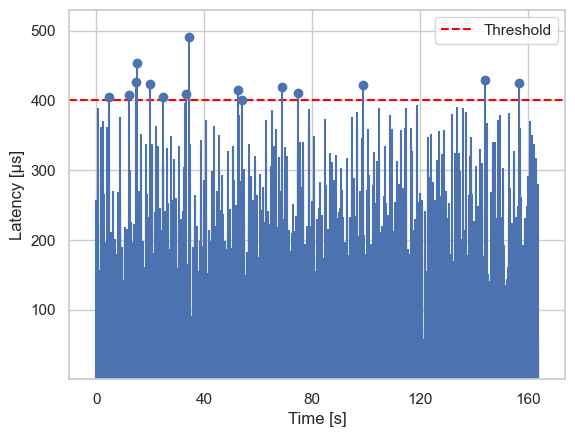

In [6]:
u = 400
exceedances = ldata[ldata['latency'] > u]
remaining = ldata[ldata['latency'] <= u]

plt.grid()
plt.axhline(u, color='red', linestyle='dashed', label='Threshold')
plt.stem(remaining['time'], remaining['latency'], linefmt='#4c72b0', markerfmt='none', basefmt='none')
markerline, _, _ = plt.stem(exceedances['time'], exceedances['latency'], linefmt='#4c72b0', markerfmt='o', basefmt='none')
plt.axis([-border, ldata['time'].max()+border, 0, 530])
plt.xticks([0, 40, 80, 120, 160])
plt.xlabel('Time [s]')
plt.yticks([100, 200, 300, 400, 500])
plt.ylabel('Latency [μs]')
plt.legend()
plt.grid()
plt.show()

## Inference

### Threshold Selection

Function was taken from https://github.com/iagolemos1/thresholdmodeling/blob/master/thresholdmodeling/thresh_modeling.py.
Slight adjustments were made to better format the labeling of the axes.

In [7]:
arr = ldata['latency'].ravel()

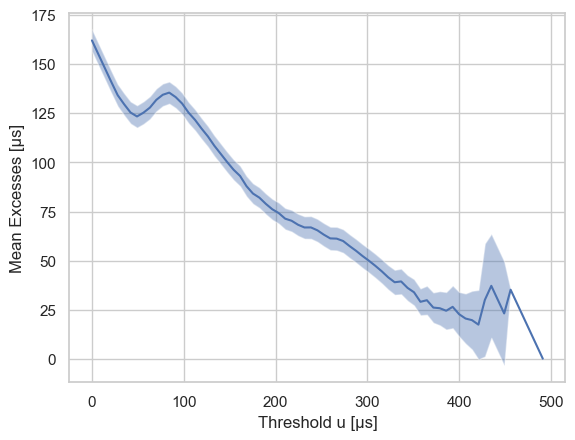

In [8]:
def MRL(sample, alpha): #MRL function

    #Defining the threshold array and its step
    step = np.quantile(sample, .995)/60
    threshold = np.arange(0, max(sample), step=step) 
    z_inverse = norm.ppf(1-(alpha/2))

    #Initialization of arrays
    mrl_array = [] #mean of excesses intialization
    CImrl = [] #confidence interval for the excesses initialization

    #First Loop for getting the mean residual life for each threshold value and the 
    #second one getting the confidence intervals for the plot
    for u in threshold:
        excess = [] #initialization of the excesses array for each loop
        for data in sample:
            if data > u:
                excess.append(data - u) #adding excesses to the excesses array
        mrl_array.append(np.mean(excess)) #adding the mean of the excesses in the mean excesses array
        std_loop = np.std(excess) #getting standard deviation in the loop
        CImrl.append(z_inverse*std_loop/(len(excess)**0.5)) #getting confidence interval 

    CI_Low = [] #initialization of the low confidence interval array
    CI_High = [] #initialization of the high confidence interval array

    #Loop to add in the confidence interval to the plot arrays
    for i in range(0, len(mrl_array)):
        CI_Low.append(mrl_array[i] - CImrl[i])
        CI_High.append(mrl_array[i] + CImrl[i])

    #Plot MRL
    plt.figure(1)
    sns.lineplot(x = threshold, y = mrl_array)
    plt.fill_between(threshold, CI_Low, CI_High, alpha = 0.4)
    return plt

plt.xticks(np.arange(0, 600, step=100))
plt.xlabel('Threshold u [μs]')
plt.yticks(np.arange(0, 200, step=25))
plt.ylabel('Mean Excesses [μs]')
plt = MRL(arr, 0.05)
plt.show()

Judging from this figure, we decide to use a threshold of u = 370μs. This leads to 42 threshold exceedances (of 1264),
a proportion of about 3.32%.

### Parameter Estimation

In [9]:
shape, scale, sample, sample_excess, sample_over_thresh = thresh_modeling.gpdfit(arr, 370, 'mle')

Estimator: MLE 
 Deviance: 357.9435 
      AIC: 361.9435 

Varying Threshold: FALSE 

  Threshold Call: 370L 
    Number Above: 42 
Proportion Above: 0.0332 

Estimates
   scale     shape  
27.81280  -0.06447  

Standard Error Type: observed 

Standard Errors
 scale   shape  
5.9551  0.1488  

Asymptotic Variance Covariance
       scale     shape   
scale  35.46336  -0.65597
shape  -0.65597   0.02215

Optimization Information
  Convergence: successful 
  Function Evaluations: 13 
  Gradient Evaluations: 6 




We estimate σ = 27.81280 and ξ = -0.06447. 95% confidence intervals for σ and ξ are about 27.81280 ± 11.671996
and -0.06447 ± 0.291648, respectively

## Model Checking

Function was taken from https://github.com/iagolemos1/thresholdmodeling/blob/master/thresholdmodeling/thresh_modeling.py. Slight adjustments were made to better format the labeling of the axes.

Estimator: MLE 
 Deviance: 357.9435 
      AIC: 361.9435 

Varying Threshold: FALSE 

  Threshold Call: 370L 
    Number Above: 42 
Proportion Above: 0.0332 

Estimates
   scale     shape  
27.81280  -0.06447  

Standard Error Type: observed 

Standard Errors
 scale   shape  
5.9551  0.1488  

Asymptotic Variance Covariance
       scale     shape   
scale  35.46336  -0.65597
shape  -0.65597   0.02215

Optimization Information
  Convergence: successful 
  Function Evaluations: 13 
  Gradient Evaluations: 6 




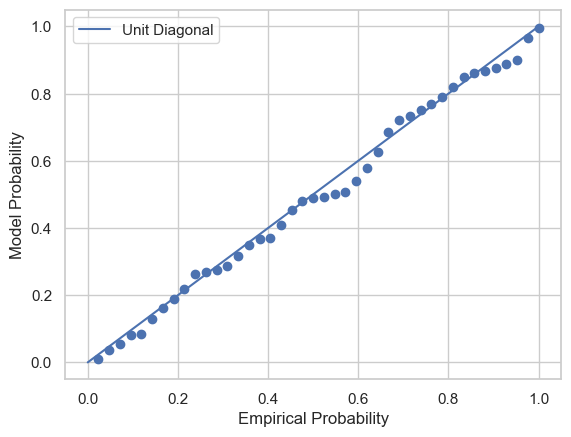

In [10]:
def ppplot(sample, threshold, fit_method, alpha):  #probability-probability plot to diagnostic the model
    [shape, scale, sample, sample_excess, sample_over_thresh] = thresh_modeling.gpdfit(sample, threshold, fit_method) #fit the data
    n = len(sample_over_thresh)
    #Getting empirical probabilities
    y = np.arange(1,n+1)/n 
    #Getting theoretical probabilities 
    cdf_pp = genpareto.cdf(sample_over_thresh, shape, loc=threshold, scale=scale)

    #Plotting PP
    plt.figure(6)
    # sns.regplot(x=y, y=cdf_pp, ci = None, line_kws={'color':'#4c72b0', 'label':'Regression Line'})
    # sns.scatterplot(x=y, y=cdf_pp)
    plt.scatter(x=y, y=cdf_pp, color='#4c72b0')
    plt.plot([0, 1], [0, 1], color='#4c72b0', label='Unit Diagonal')
    plt.legend()
    return plt

plt = ppplot(arr, 370, 'mle', 0.05)
plt.xlabel('Empirical Probability')
plt.ylabel('Model Probability')
plt.show()

We come to the conclusion that the derived parameter estimates are reasonably accurate.

## Return Value Analysis

In [11]:
def return_value(sample_real, threshold, alpha, return_period, fit_method): #return value plot and return value estimative
    sample = np.sort(sample_real) 
    sample_excess = []
    sample_over_thresh = []
    for data in sample:
        if data > threshold+0.00001:
            sample_excess.append(data - threshold)
            sample_over_thresh.append(data)

    rdata = FloatVector(sample)
    fit = POT.fitgpd(rdata, threshold, est = fit_method) #fit data 
    shape = fit[0][1]  
    scale = fit[0][0]
    
    #Computing the return value for a given return period with the confidence interval estimated by the Delta Method
    m = return_period
    Eu = len(sample_over_thresh)/len(sample)
    x_m = threshold + (scale/shape)*(((m*Eu)**shape) - 1)

    #Solving the delta method    
    d = Eu*(1-Eu)/len(sample)
    e = fit[3][0]
    f = fit[3][1]
    g = fit[3][2]
    h = fit[3][3]
    a = (scale*(m**shape))*(Eu**(shape-1))
    b = (shape**-1)*(((m*Eu)**shape) - 1)
    c = (-scale*(shape**-2))*((m*Eu)**shape - 1) + (scale*(shape**-1))*((m*Eu)**shape)*mt.log(m*Eu)
    CI = (norm.ppf(1-(alpha/2))*((((a**2)*d) + (b*((c*g) + (e*b))) + (c*((b*f) + (c*h))))**0.5))

    print('The return value for the given return period is {} \u00B1 {}'.format(x_m, CI))
    
return_value(arr, 370, 0.05, 10000, 'mle')

The return value for the given return period is 504.70207554558453 ± 75.6412466541457


We conclude that the 10000-observation return level is approximately 505μs.

In [12]:
packets_per_second = len(arr) / (ldata['time'].max())
minutes_for_10000_packets = (10000 / packets_per_second)/60
minutes_for_10000_packets

21.589266081882908

10000 observation correspond to roughly 22 minutes when assuming constant rate of packets per second.

In [13]:
ldata['latency'].max()

491.338

In [14]:
(ldata['time'].max())/60

2.72888323275

The original data have a latency maximum of about 491μs and consist of internet packets sent over a time span of about 2.7 minutes.